In [48]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# Create output folder
import os
output_folder = "recommendations"
os.makedirs(output_folder, exist_ok=True)

In [49]:
# URLs
URL_GAINERS = "https://query1.finance.yahoo.com/v1/finance/screener/predefined/saved?scrIds=day_gainers&count=250"
URL_ACTIVE = "https://query1.finance.yahoo.com/v1/finance/screener/predefined/saved?scrIds=most_actives&count=250"
URL_TRENDING = "https://query1.finance.yahoo.com/v1/finance/screener/predefined/saved?scrIds=trending_tickers&count=250"

In [50]:
def fetch_screener(scrId, count=250): 
    url = f"https://query1.finance.yahoo.com/v1/finance/screener/predefined/saved?scrIds={scrId}&count={count}"
    try:
        r = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})
        data = r.json()["finance"]["result"][0]["quotes"]
        return pd.DataFrame(data)
    except Exception as e:
        print(f"Error loading screener {scrId}: {e}")


In [51]:
def fetch_trending():
    url = "https://query1.finance.yahoo.com/v1/finance/trending/US"
    try:
        r = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})
        data = r.json()["finance"]["result"][0]["quotes"]
        return pd.DataFrame(data)
    except Exception as e:
        print(f"Error loading trending {scrId}: {e}")

In [52]:
import re

def filter_equities(df):
    eq = []
    for s in df["symbol"]:
        if re.fullmatch(r"[A-Za-z][A-Za-z0-9\.-]{0,9}", s):
            eq.append(s)
    return pd.DataFrame({"symbol": eq})


In [53]:
print("Downloading Yahoo lists...")

df_gainers = fetch_screener("day_gainers")
df_active  = fetch_screener("most_actives")
df_trending_raw = fetch_trending()
df_trending = filter_equities(df_trending_raw)


print("Gainers:", len(df_gainers))
print("Most Active:", len(df_active))
print("Trending:", len(df_trending))

combined = pd.concat([df_gainers, df_active, df_trending], ignore_index=True)
combined.drop_duplicates(subset="symbol", inplace=True)

print("Total unique hot symbols:", len(combined))


Gainers: 17
Most Active: 18
Trending: 20
Total unique hot symbols: 51


In [54]:
def fix_num(x):
    """
    Convert Yahoo formatted numbers:
    '1.2M', '330K', '2.3B' → float
    """
    if x is None:
        return np.nan
    if isinstance(x, (int, float)):
        return float(x)

    x = str(x).replace(",", "")

    try:
        if x.endswith("M"):
            return float(x[:-1]) * 1e6
        if x.endswith("B"):
            return float(x[:-1]) * 1e9
        if x.endswith("K"):
            return float(x[:-1]) * 1e3
        return float(x)
    except:
        return np.nan

numeric_cols = [
    "regularMarketPrice",
    "regularMarketChangePercent",
    "regularMarketChange",
    "regularMarketVolume",
    "averageDailyVolume3Month",
    "marketCap"
]

for col in numeric_cols:
    if col in combined.columns:
        combined[col] = combined[col].apply(fix_num)

In [55]:
df = combined.copy()

# Volume Spike Score
df["VolumeSpike"] = df["regularMarketVolume"] / df["averageDailyVolume3Month"]
df["VolumeScore"] = df["VolumeSpike"].rank(pct=True)

# Momentum Score (based on daily % change)
df["MomentumScore"] = df["regularMarketChangePercent"].rank(pct=True)

# Volatility Score (higher movement = more hot)
df["VolatilityScore"] = df["regularMarketChange"].abs().rank(pct=True)

# Trend Score (proxy: price vs avg volume)
df["TrendScore"] = (df["regularMarketPrice"] / (df["averageDailyVolume3Month"] + 1)).rank(pct=True)

# Final score
df["HotScore"] = (
    0.35 * df["MomentumScore"] +
    0.35 * df["VolumeScore"] +
    0.20 * df["VolatilityScore"] +
    0.10 * df["TrendScore"]
)

df.sort_values("HotScore", ascending=False, inplace=True)

# Keep relevant columns
output_df = df[[
    "symbol",
    "regularMarketPrice",
    "regularMarketChangePercent",
    "regularMarketVolume",
    "averageDailyVolume3Month",
    "marketCap",
    "VolumeSpike",
    "MomentumScore",
    "VolumeScore",
    "VolatilityScore",
    "TrendScore",
    "HotScore"
]]

In [56]:
top50 = output_df.head(50)


timestamp = datetime.now().strftime("%Y%m%d%H%M%S") 
file_path = os.path.join(output_folder, f"hot_stocks_{timestamp}.csv")
top50.to_csv(file_path, index=False)

print("\n🔥 Saved TOP 50 hot stocks to:", file_path)
top50



🔥 Saved TOP 50 hot stocks to: recommendations\hot_stocks_20251118154352.csv


,symbol,regularMarketPrice,regularMarketChangePercent,regularMarketVolume,averageDailyVolume3Month,marketCap,VolumeSpike,MomentumScore,VolumeScore,VolatilityScore,TrendScore,HotScore
0,DGNX,16.1145,18.576157,630021.0,767879.0,3.271330e+09,0.820469,1.000000,0.909091,0.787879,0.878788,0.913636
6,MDT,101.4600,5.314514,3443125.0,6931262.0,1.301342e+11,0.496753,0.848485,0.818182,0.939394,0.848485,0.856061
4,AS,32.6451,6.335827,2996199.0,5230676.0,1.810404e+10,0.572813,0.909091,0.848485,0.757576,0.636364,0.830303
17,LNW,86.2200,0.000000,38854866.0,1955942.0,7.028989e+09,19.865040,0.363636,1.000000,1.000000,0.969697,0.774242
10,TPC,61.6500,4.971909,65975.0,550707.0,3.251621e+09,0.119801,0.787879,0.515152,0.848485,1.000000,0.725758
1,JHX,18.2984,9.440201,1054079.0,8526978.0,1.059939e+10,0.123617,0.969697,0.575758,0.696970,0.424242,0.722727
5,TERN,26.9500,5.441596,346824.0,2393689.0,2.427650e+09,0.144891,0.878788,0.606061,0.636364,0.757576,0.722727
11,AXTA,29.2400,3.761531,2213439.0,3475121.0,6.332628e+09,0.636939,0.636364,0.878788,0.515152,0.727273,0.706061
2,QUBT,12.2881,6.853046,9588153.0,36656675.0,2.754050e+09,0.261566,0.939394,0.757576,0.424242,0.272727,0.706061
7,FCX,40.8400,4.691110,3894009.0,18061845.0,5.864341e+10,0.215593,0.727273,0.727273,0.727273,0.454545,0.700000


In [57]:
top50['symbol']

0        DGNX
6         MDT
4          AS
17        LNW
10        TPC
1         JHX
5        TERN
11       AXTA
2        QUBT
7         FCX
15         XP
3        ONDS
18       MTSR
25         FI
29      GOOGL
12       LQDA
30       BMNR
8          GT
34       AMZN
19       NVDA
24       TSLA
9        WULF
14        LGN
13       SRRK
32       PLTR
16       ORLA
26       SOFI
28       SNAP
27        NIO
31       INTC
33       BBAI
22       PLUG
20       OPEN
35    BTC-USD
36         HD
37       OLMA
38        NET
39    ETH-USD
40       BIDU
41       KLAR
42    XRP-USD
44       CANF
45       PACS
46        PDD
47    BTC-CAD
48       ARVN
49    SOL-USD
50       GRRR
51       INTU
52        LOW
Name: symbol, dtype: object

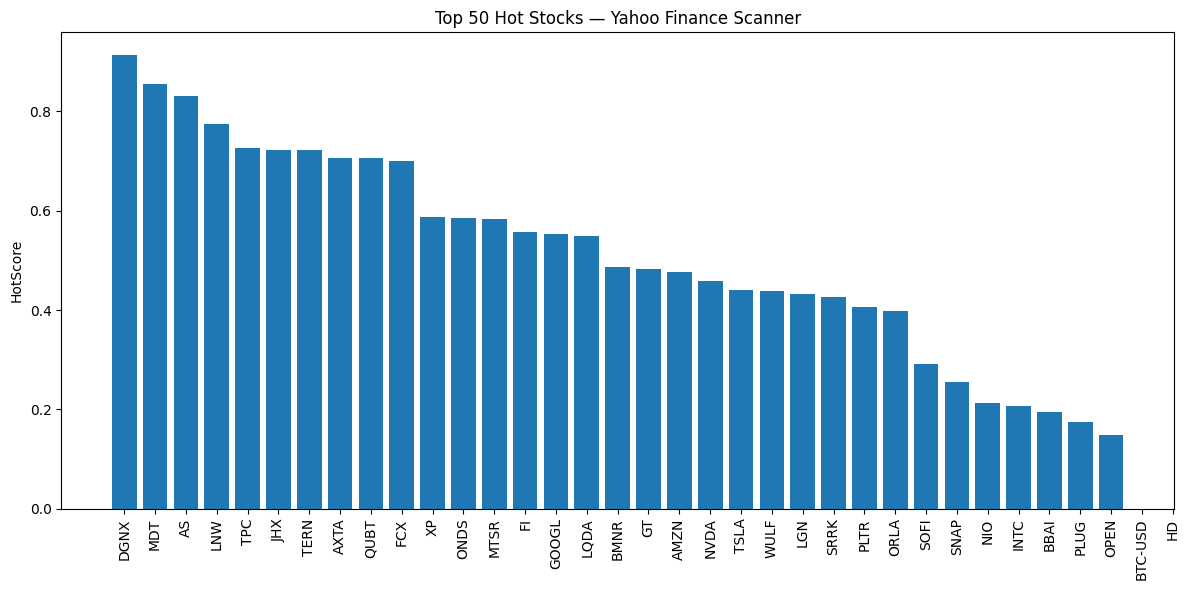

In [58]:

# --------------------------------------------------------
# 6. Plot Heat Bar
# --------------------------------------------------------

plt.figure(figsize=(12, 6))
plt.bar(top50["symbol"], top50["HotScore"])
plt.xticks(rotation=90)
plt.title("Top 50 Hot Stocks — Yahoo Finance Scanner")
plt.ylabel("HotScore")
plt.tight_layout()
plt.show()